In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from collections import defaultdict
from tqdm.notebook import tqdm


from networks import DeepSurv, NegativeLogLikelihood
from utils import read_config, c_index

import torch

In [2]:
device = 'cuda:0'

In [3]:
config = {'train': {'epochs': 300,
  'learning_rate': 0.003194,
  'lr_decay_rate': 0.0003173,
  'optimizer': 'Adam'},
 'network': {'drop': 0.401,
  'norm': True,
  'dims': [8, 17, 1],
  'activation': 'ReLU',
  'l2_reg': 0}}

model = DeepSurv(config['network'], device)
print(model)

loss_function = NegativeLogLikelihood(config['network']).to(device)
print(loss_function)


DeepSurv(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=17, bias=True)
    (1): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.401, inplace=False)
    (4): Linear(in_features=17, out_features=1, bias=True)
    (5): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
)
NegativeLogLikelihood()


In [4]:
optimizer = eval('torch.optim.{}'.format(config['train']['optimizer']))(
        model.parameters(), lr=config['train']['learning_rate'])

In [5]:
from sksurv.datasets import load_veterans_lung_cancer
data_x, data_y = load_veterans_lung_cancer()
life = pd.concat([data_x, pd.DataFrame(data_y)], axis = 1)
from sksurv.preprocessing import OneHotEncoder

life = OneHotEncoder().fit_transform(life)

life

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test,Status,Survival_in_days
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0,True,72.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0,True,411.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0,True,228.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0,True,126.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0,True,118.0
...,...,...,...,...,...,...,...,...,...,...
132,65.0,1.0,0.0,0.0,75.0,1.0,0.0,1.0,True,133.0
133,64.0,1.0,0.0,0.0,60.0,5.0,0.0,1.0,True,111.0
134,67.0,1.0,0.0,0.0,70.0,18.0,1.0,1.0,True,231.0
135,65.0,1.0,0.0,0.0,80.0,4.0,0.0,1.0,True,378.0


In [6]:
class SurvivalDataset(torch.utils.data.Dataset):
    
    def __init__(self, covx, event, time):
        '''
        note that inputs are normalized numpy
        '''
        self.covx = covx
        self.event = event
        self.time = time
        print(covx.shape, event.shape, time.shape)
    
    def __getitem__(self, index):
        # gets data with index of item
        X_item = self.covx[index] # (m)
        e_item = self.event[index] # (1)
        y_item = self.time[index] # (1)

        # constructs torch.Tensor object
        X_tensor = torch.from_numpy(X_item).to(torch.float32)
        e_tensor = torch.from_numpy(e_item).to(torch.float32)
        y_tensor = torch.from_numpy(y_item).to(torch.float32)
        return X_tensor, y_tensor, e_tensor

    def __len__(self):
        return self.covx.shape[0]

In [94]:
cols = list(life.columns)

cols.remove('Status')
cols.remove('Survival_in_days')
covx = life

import pandas as pd
from sklearn import preprocessing

x = covx.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
covx, event, time = df[list(range(8))].to_numpy(), df[[8]].to_numpy(), df[[9]].to_numpy()

In [8]:
ratio = 0.9
train_valid_dataset = SurvivalDataset(covx[:100, :], event[:100], time[:100])

train_len = int(len(train_valid_dataset)*ratio)
valid_len = len(train_valid_dataset) - train_len

train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [train_len, valid_len])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_dataset.__len__())
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=valid_dataset.__len__())



test_dataset = SurvivalDataset(covx[100:, :], event[100:], time[100:])
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_dataset.__len__())

print(train_dataset.__len__(), valid_dataset.__len__(), test_dataset.__len__())

(100, 8) (100, 1) (100, 1)
(37, 8) (37, 1) (37, 1)
90 10 37


In [9]:
class Trainer():
    def initialize(self, train_loader, valid_loader, test_loader, optimizer, model, loss_function, c_index_function, device, freq = 100):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.model = model.to(device)
        self.loss_function = loss_function.to(device)
        self.c_index_function = c_index_function
        self.device = device
        self.freq = freq
    
    def one_epoch_train(self, epoch):
        self.model.train()
        loss_total = list()
        c_index_total = list()
        for x, y, e in self.train_loader:
            x = x.to(self.device)
            y = y.to(self.device)
            e = e.to(self.device)
            risk_pred = self.model(x)
            train_loss = self.loss_function(risk_pred, y, e, self.model, self.device)
            print(train_loss)
            train_c = self.c_index_function(-risk_pred, y, e)

            self.optimizer.zero_grad()
            train_loss.backward()
            self.optimizer.step()

            loss_total.append(train_loss.cpu().detach().item())
            c_index_total.append(train_c)

        if epoch % self.freq == 0 : print(f'{epoch} : {round(np.array(loss_total).mean(), 3)} / {round(np.array(c_index_total).mean(), 3)}')
        return np.array(loss_total).mean(), np.array(c_index_total).mean()
    
    def one_epoch_valid(self, epoch):
        self.model.eval()
        loss_total = list()
        c_index_total = list()
        with torch.no_grad():
            for x, y, e in self.valid_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                e = e.to(self.device)

                risk_pred = self.model(x).to(self.device)
                valid_loss = self.loss_function(risk_pred, y, e, self.model, self.device)
                valid_c = self.c_index_function(-risk_pred, y, e)

                loss_total.append(valid_loss.cpu().detach().item())
                c_index_total.append(valid_c)


            if epoch % self.freq == 0 : print(f'{epoch} : {round(np.array(loss_total).mean(), 3)} / {round(np.array(c_index_total).mean(), 3)}')
            return np.array(loss_total).mean(), np.array(c_index_total).mean()

    def test(self):
        self.model.eval()
        with torch.no_grad():
            for x, y, e in self.test_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                e = e.to(self.device)

                risk_pred = self.model(x).to(self.device)
                test_loss = self.loss_function(risk_pred, y, e, self.model, self.device)
                test_c = self.c_index_function(-risk_pred, y, e)


                print(f'Test : {round(test_loss.cpu().detach().item(), 3)} / {round(test_c, 3)}')

In [10]:
trainer = Trainer()
trainer.initialize(
    train_loader,
    valid_loader, 
    test_loader,
    optimizer,
    model,
    loss_function,
    c_index_function = c_index,
    device = 'cuda:0'
)

In [11]:
for i in model.model.parameters():break
i.device

device(type='cuda', index=0)

In [12]:
epochs = 3000
train_result = list()
valid_result = list()
for epoch in tqdm(range(epochs)):
    train_result.append(trainer.one_epoch_train(epoch))
    valid_result.append(trainer.one_epoch_valid(epoch))
trainer.test()

train_result = np.stack(train_result)
valid_result = np.stack(valid_result)

  0%|          | 0/3000 [00:00<?, ?it/s]

tensor(-0.0223, device='cuda:0', grad_fn=<AddBackward0>)
0 : -0.022 / 0.603
0 : 0.002 / 0.455
tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0368, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0703, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0506, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0811, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.1131, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0955, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0976, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.1121, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0801, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.1160, device='cuda:0', grad_fn=<AddBackward0

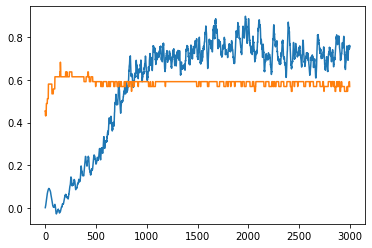

In [13]:
plt.plot(valid_result)

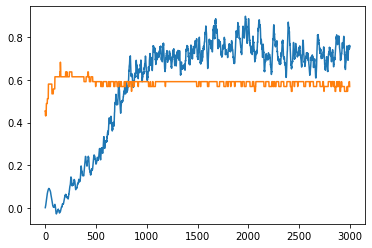

In [14]:
plt.plot(valid_result)

In [15]:
trainer.test()

Test : 1.755 / 0.689


In [133]:
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        x = torch.tensor(x.to_numpy(), dtype=torch.float32).to('cuda:0')
        x = self.model(x)
        x = torch.softmax(x, dim=-1)
        return x.detach().cpu().numpy()

    # Add the predict method
    def predict(self, x):
        probabilities = self.forward(x)
        return probabilities[:, 1].reshape(-1, 1)

wrapped_model = WrappedModel(model).to('cuda:0')


In [134]:
torch.tensor(X_df.to_numpy(), dtype=torch.float32).to('cuda:0')

tensor([[-0.3504,  1.6330],
        [ 0.8256,  0.3933],
        [-1.0693, -1.1655],
        [-1.3915,  1.3353],
        [ 0.3950,  0.7786],
        [-1.5149,  1.7006],
        [ 1.1561, -0.9671],
        [-0.9844, -1.0690],
        [-0.5817,  0.1331],
        [-0.1615, -0.6893],
        [ 0.4304, -1.2236],
        [-0.6215, -0.4247],
        [-0.0822,  1.0501],
        [-0.9257,  0.0960],
        [ 0.3664, -1.5512],
        [ 0.4162, -1.1143],
        [-1.3686,  1.6266],
        [ 1.5943,  1.1319],
        [-0.5804, -1.3709],
        [ 0.6685, -0.1649],
        [-1.1811,  0.0289],
        [-1.4695,  1.4873],
        [-0.7312,  0.6182],
        [-0.5571,  0.1166],
        [ 0.2160, -1.0639],
        [ 1.6073,  1.0147],
        [ 1.5083,  1.4362],
        [ 0.3844,  1.5315],
        [-1.2915, -1.0247],
        [-1.4338, -0.5692],
        [-0.3039, -0.7593],
        [ 1.1439, -0.4585],
        [-0.6583,  0.1962],
        [-1.1190,  1.1100],
        [-1.3373,  1.7604],
        [ 0.9580, -1

In [135]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [136]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pdpbox import pdp

# Create a toy dataset
np.random.seed(42)
X = np.random.rand(100, 2)
y = np.random.randint(0, 2, 100)

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_df = pd.DataFrame(X, columns=[1, 2])
X_df


,1,2
0,-0.350389,1.633029
1,0.825606,0.393304
2,-1.069308,-1.165488
3,-1.391507,1.335338
4,0.395025,0.778593
...,...,...
95,-1.276296,1.444640
96,1.379708,0.514591
97,-0.467216,-0.485103
98,0.805741,1.444269


In [137]:
# Prepare the dataset as a pandas DataFrame
X_df = df[list(range(8))]

# Generate the PDP plot
pdp_feature_1 = pdp_isolate(
    model=wrapped_model,
    dataset=X_df,
    model_features=list(range(8)),
    feature=7
)
pdp_plot(pdp_feature_1, 7)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (137x8 and 2x10)

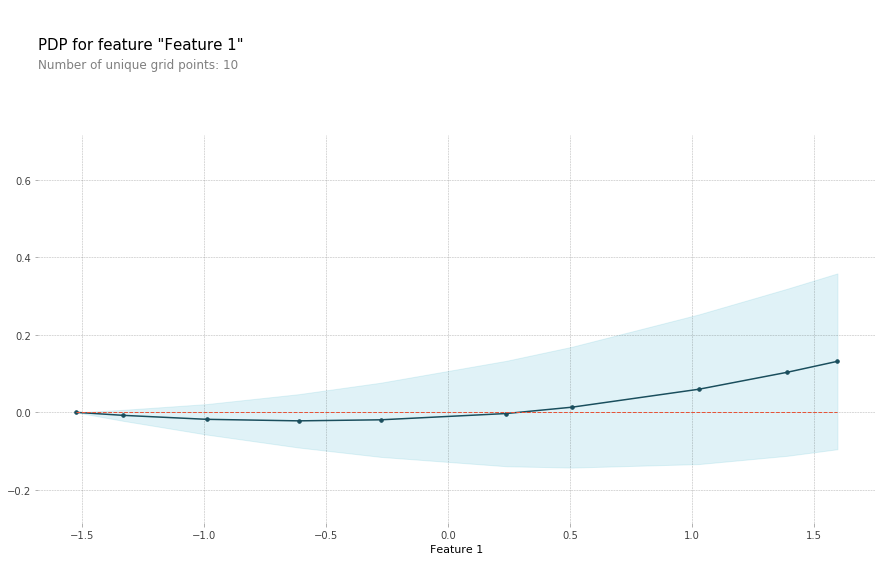

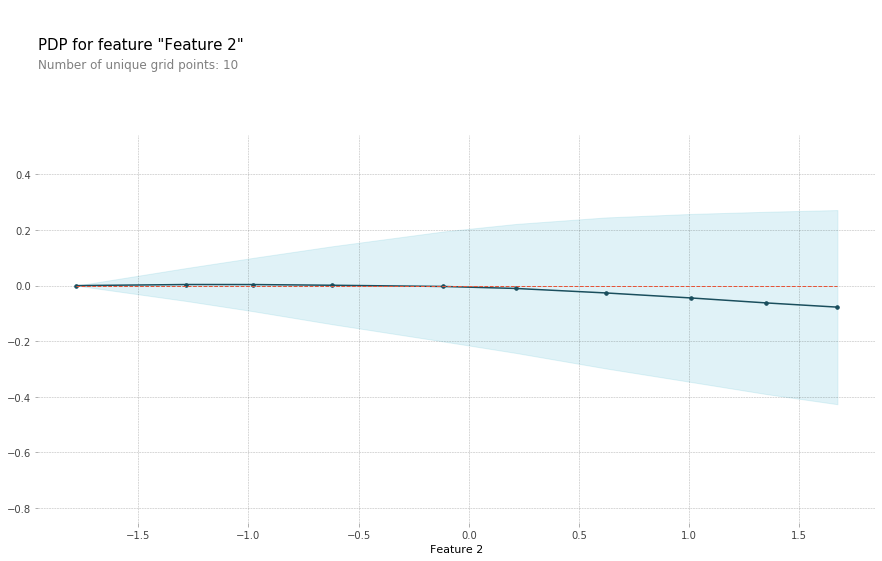

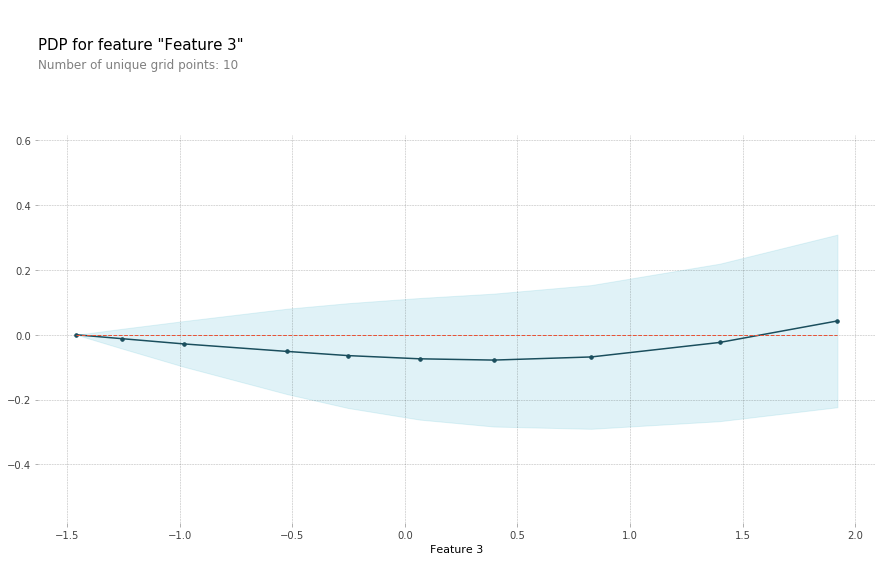

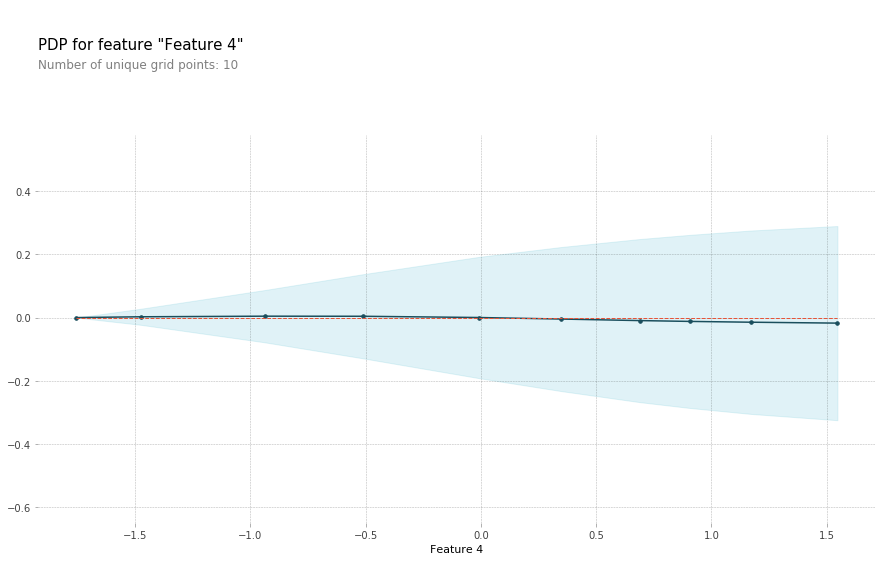

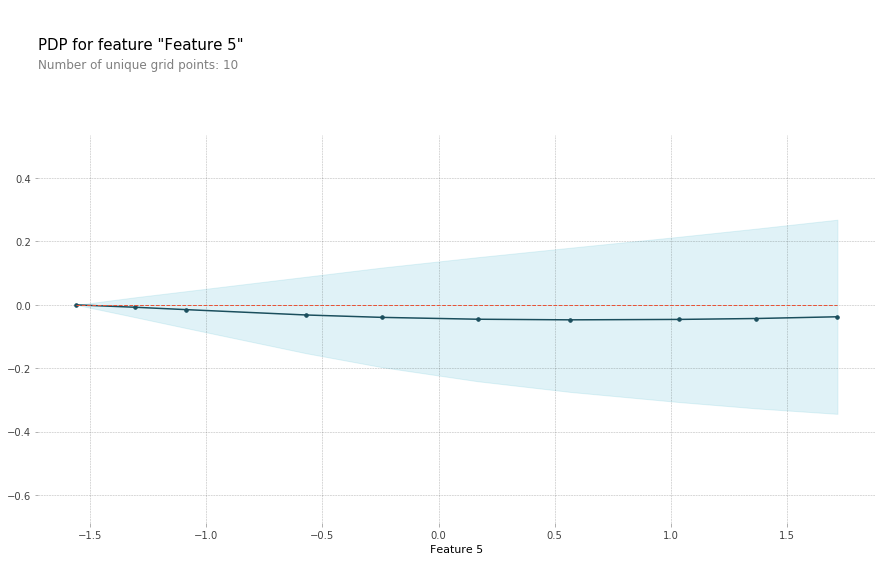

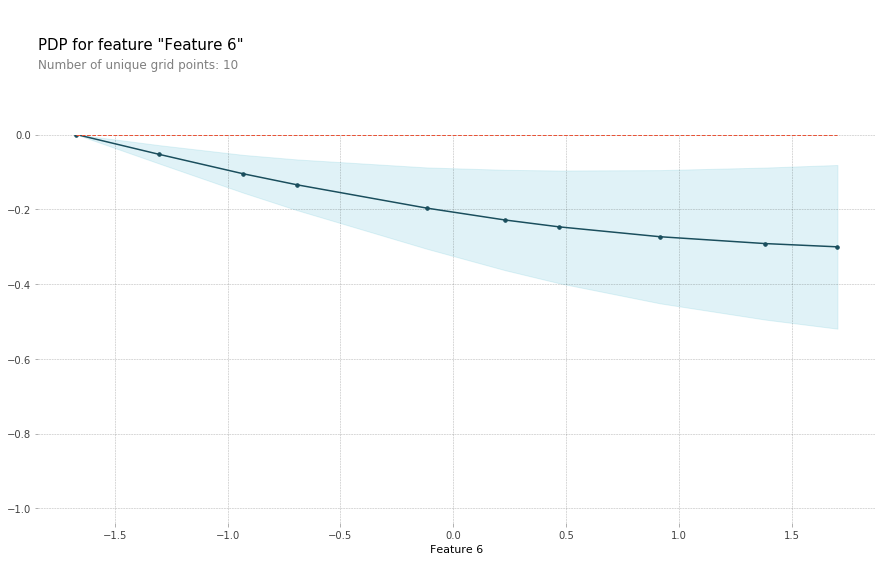

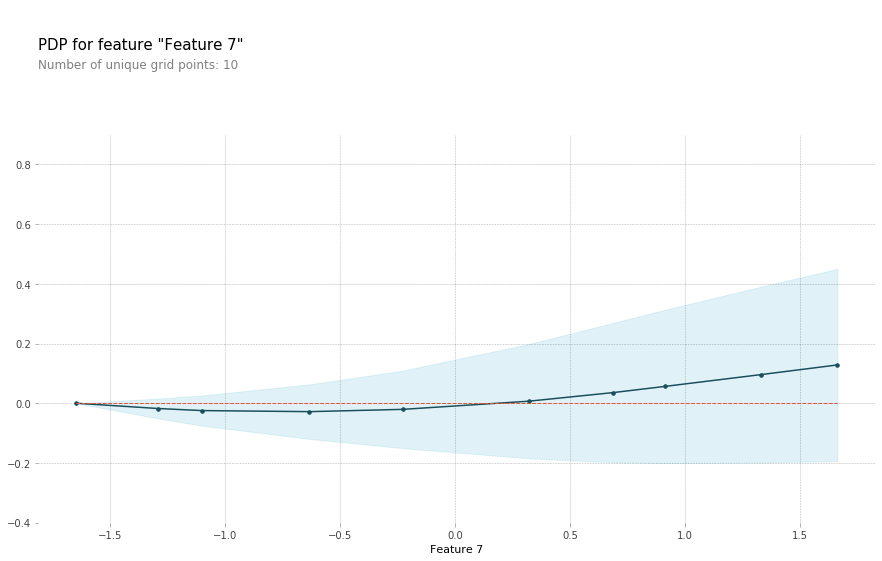

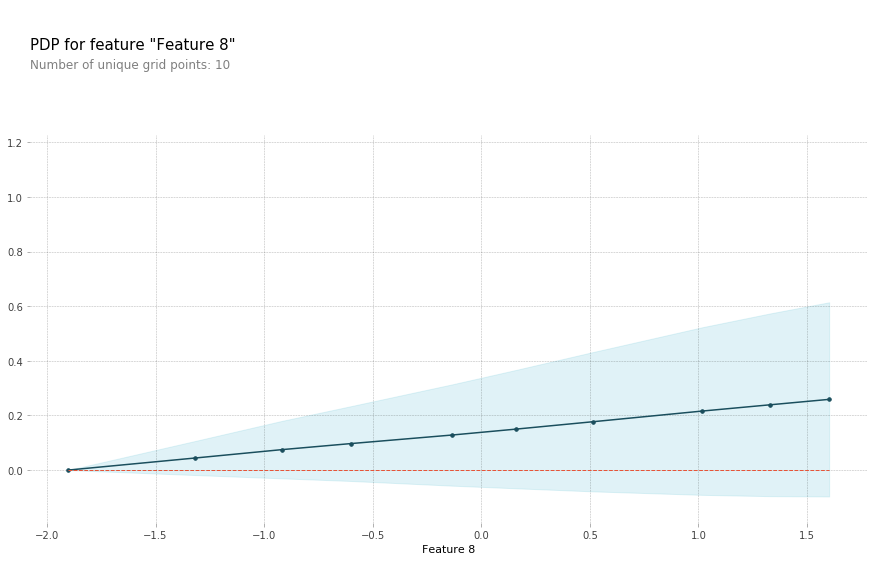

In [140]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pdpbox.pdp import pdp_isolate, pdp_plot

# Create a toy dataset
np.random.seed(42)
X = np.random.rand(100, 8)
y = np.random.rand(100)

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple PyTorch model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Wrap the PyTorch model to work with pdpbox
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        x = torch.tensor(x.to_numpy(), dtype=torch.float32).to(device)
        x = self.model(x)
        return x.detach().cpu().numpy()

    # Add the predict method
    def predict(self, x):
        return self.forward(x)

wrapped_model = WrappedModel(model)

# Prepare the dataset as a pandas DataFrame
feature_names = [f'feature_{i}' for i in range(1, 9)]
X_df = pd.DataFrame(X, columns=feature_names)

import matplotlib.pyplot as plt

# Generate the PDP plots for all features
for i, feature in enumerate(feature_names, 1):
    pdp_feature = pdp_isolate(
        model=wrapped_model,
        dataset=X_df,
        model_features=feature_names,
        feature=feature
    )
    fig, axes = pdp_plot(pdp_feature, f'Feature {i}')
    plt.show()